<a href="https://colab.research.google.com/github/Athugodage/RuLawSimplification/blob/main/corpus_analysis/acta_petropolitana_linguistica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets

In [10]:
!pip install razdel

In [2]:
import opendatasets as od

od.download('https://www.kaggle.com/datasets/athugodage/russian-legal-text-parallel-corpus')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: athugodage
Your Kaggle Key: ··········


100%|██████████| 25.9M/25.9M [00:00<00:00, 126MB/s] 


In [3]:
import pandas as pd

df = pd.read_csv('/content/russian-legal-text-parallel-corpus/legal_text_corpus.csv')

In [5]:
df['Год'] = df['Дата'].apply(lambda x: x[:4])

In [7]:
df[['Текст', 'Год']]

,Текст,Год
0,1. Внести в Указ временно исполняющего обязанн...,2022
1,Именем Российской Федерации Конституционный С...,2022
2,В целях обеспечения единства практики применен...,2022
3,Принят Государственной Думой 10 ноября 2022 го...,2022
4,Принят Государственной Думой 10 ноября 2022 го...,2022
...,...,...
2958,Правительство Российской Федерации постановляе...,2009
2959,В соответствии с частью второй статьи 751 Угол...,2009
2960,Правительство Российской Федерации постановляе...,2009
2961,Зарегистрирован в Минюсте РФ 10 июля 2009 г. ...,2009


In [9]:
import nltk
from numpy import mean as mean

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [11]:

## GUNNING FOG READABILITY INDEX

def gunning_fog(text):
  text = str(text)

  tokens = nltk.word_tokenize(text)
  tokens_length = len(tokens)
  sent_length = len(nltk.sent_tokenize(text))
  complex_tokens_len = len([tok for tok in tokens if len(tok) > 6])
  formule = 0.4 * (tokens_length / sent_length) + 100 * (complex_tokens_len / tokens_length)
  return formule

In [15]:
from tqdm import tqdm

tqdm.pandas()

df['GunFog'] = df['Текст'].progress_apply(lambda t: gunning_fog(t))

100%|██████████| 2963/2963 [01:43<00:00, 28.60it/s]


In [16]:

from razdel import sentenize, tokenize


def all_syl_number(string):
    num_vowels = 0

    for char in string.lower():
        if char in "яыуаеиоюэ":
            num_vowels = num_vowels+1

    return num_vowels

def total_words(string):
    return len(list(tokenize(string)))

def total_sents(string):
    return len(list(sentenize(string)))

def fkgl(string):
    n_of_sents = total_sents(string)
    n_of_words = total_words(string)
    n_of_syls = all_syl_number(string)
    fkgl = (0.39 * (n_of_words/n_of_sents) + 11.8 * (n_of_syls/n_of_words)) - 15.39
    return float(fkgl)

In [17]:
df['FKGL'] = df['Текст'].progress_apply(lambda t: fkgl(t))

100%|██████████| 2963/2963 [02:25<00:00, 20.36it/s]


In [21]:
df['FKGL'] = df['FKGL'].apply(lambda x: round(x, 1))
df['GunFog'] = df['GunFog'].apply(lambda x: round(x, 1))

In [2]:
import pandas as pd

df = pd.read_parquet('/content/petropolitana_simp_rate.parquet')

In [10]:
df = df[:-1]

In [14]:
def detect(data):
    if "указ" in data.split(' ')[0].lower():
        return "Указ"
    elif "постановление" in data.split(' ')[0].lower():
        return "Постановление"
    elif "федеральный" in data.split(' ')[0].lower():
        return "Закон"
    elif "приказ" in data.split(' ')[0].lower():
        return "Приказ"
    elif "изменения" or "поправки" in data:
        return "Поправки"
    else:
        return "Другое"

df['Тип закона'] = df['Название документа'].apply(detect)


<ipython-input-14-fc534750a2ad>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Тип закона'] = df['Название документа'].apply(detect)


In [15]:
df['Тип закона']

0                Указ
1       Постановление
2       Постановление
3               Закон
4               Закон
            ...      
2957         Поправки
2958    Постановление
2959         Поправки
2960         Поправки
2961    Постановление
Name: Тип закона, Length: 2962, dtype: object

<Axes: xlabel='Год'>

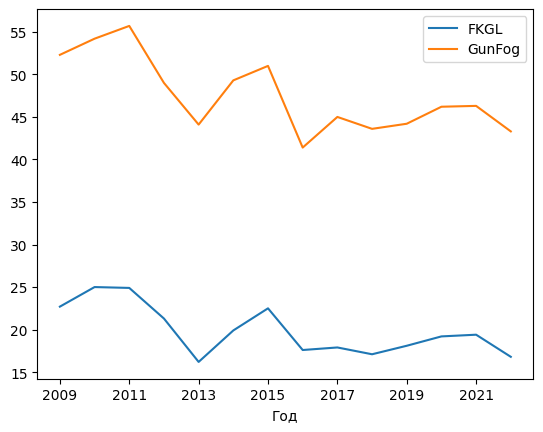

In [27]:
df.groupby(["Тип закона", 'Год']).agg({'FKGL': 'mean',
                                'GunFog': 'mean'}).apply(lambda x: round(x, 1)).loc['Закон'].plot()

<Axes: xlabel='Год'>

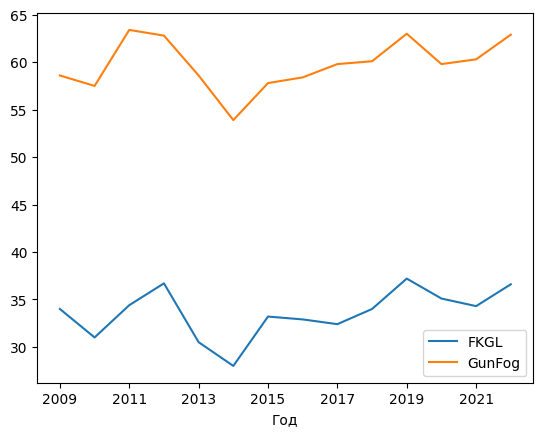

In [28]:
df.groupby(["Тип закона", 'Год']).agg({'FKGL': 'mean',
                                'GunFog': 'mean'}).apply(lambda x: round(x, 1)).loc['Постановление'].plot()

<Axes: xlabel='Год'>

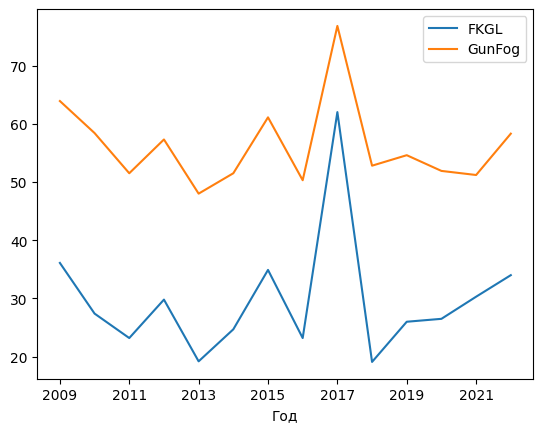

In [29]:
df.groupby(["Тип закона", 'Год']).agg({'FKGL': 'mean',
                                'GunFog': 'mean'}).apply(lambda x: round(x, 1)).loc['Указ'].plot()

<Axes: xlabel='Год'>

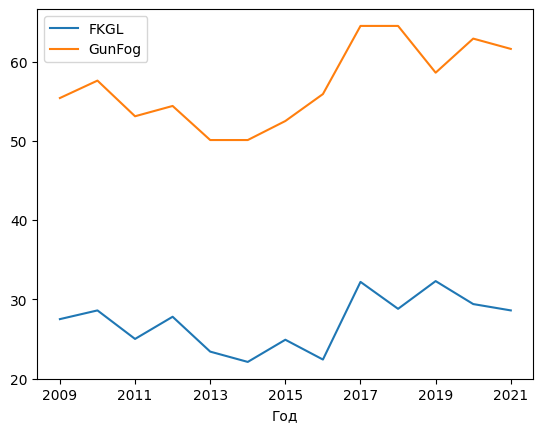

In [30]:
df.groupby(["Тип закона", 'Год']).agg({'FKGL': 'mean',
                                'GunFog': 'mean'}).apply(lambda x: round(x, 1)).loc['Поправки'].plot()

<Axes: xlabel='Год'>

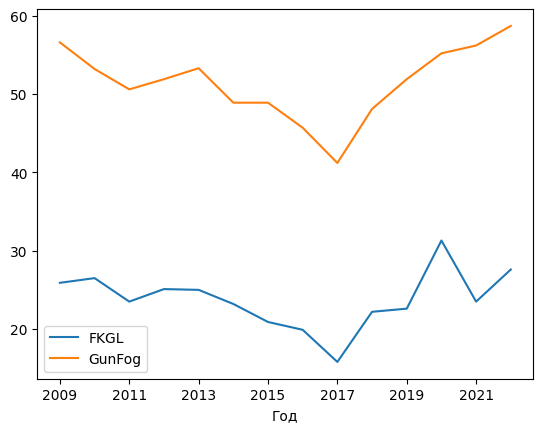

In [31]:
df.groupby(["Тип закона", 'Год']).agg({'FKGL': 'mean',
                                'GunFog': 'mean'}
                                      ).apply(lambda x: round(x, 1)).loc['Приказ']

<Figure size 1600x480 with 0 Axes>

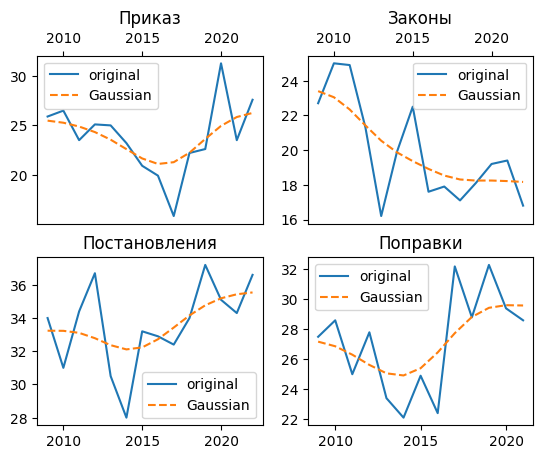

<Figure size 200x200 with 0 Axes>

In [134]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(20, 6), dpi=80)

fig, axes = plt.subplots(nrows=2, ncols=2)

plt.title('FKGL')
ax1, ax2, ax3, ax4 = axes.flatten()


data = df.groupby(["Тип закона", 'Год']).agg({'FKGL': 'mean',
                                'GunFog': 'mean'}
                                      ).apply(lambda x: round(x, 1))




y = data.loc['Приказ']['FKGL'].to_list()
y_smoothed = gaussian_filter1d(y, sigma=2)
x = [i for i in range(2009, 2023)]
ax1.plot(x, y, label='original')
ax1.plot(x, y_smoothed, label='Gaussian', linestyle='dashed')
ax1.set_title('Приказ')
ax1.xaxis.tick_top()
ax1.legend()

y = data.loc['Закон']['FKGL'].to_list()
y_smoothed = gaussian_filter1d(y, sigma=2)
x = [i for i in range(2009, 2023)]
ax2.plot(x, y, label='original')
ax2.plot(x, y_smoothed, label='Gaussian', linestyle='dashed')
ax2.set_title('Законы')
ax2.xaxis.tick_top()
ax2.legend()


y = data.loc['Постановление']['FKGL'].to_list()
y_smoothed = gaussian_filter1d(y, sigma=2)
x = [i for i in range(2009, 2023)]
ax3.plot(x, y, label='original')
ax3.plot(x, y_smoothed, label='Gaussian', linestyle='dashed')
ax3.set_title('Постановления')
ax3.legend()


y = data.loc['Поправки']['FKGL'].to_list()
y_smoothed = gaussian_filter1d(y, sigma=2)
x = [i for i in range(2009, 2022)]
ax4.plot(x, y, label='original')
ax4.plot(x, y_smoothed, label='Gaussian', linestyle='dashed')
ax4.set_title('Поправки')
ax4.legend()

figure(figsize=(2, 2))
plt.suptitle('FKGL', color='red', style='italic', fontsize=20)
plt.show()

<Figure size 1600x480 with 0 Axes>

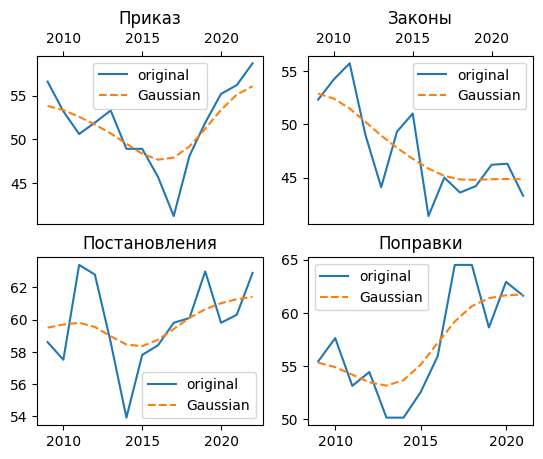

<Figure size 200x200 with 0 Axes>

In [135]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(20, 6), dpi=80)

fig, axes = plt.subplots(nrows=2, ncols=2)

plt.title('FKGL')
ax1, ax2, ax3, ax4 = axes.flatten()


data = df.groupby(["Тип закона", 'Год']).agg({'FKGL': 'mean',
                                'GunFog': 'mean'}
                                      ).apply(lambda x: round(x, 1))




y = data.loc['Приказ']['GunFog'].to_list()
y_smoothed = gaussian_filter1d(y, sigma=2)
x = [i for i in range(2009, 2023)]
ax1.plot(x, y, label='original')
ax1.plot(x, y_smoothed, label='Gaussian', linestyle='dashed')
ax1.set_title('Приказ')
ax1.xaxis.tick_top()
ax1.legend()

y = data.loc['Закон']['GunFog'].to_list()
y_smoothed = gaussian_filter1d(y, sigma=2)
x = [i for i in range(2009, 2023)]
ax2.plot(x, y, label='original')
ax2.plot(x, y_smoothed, label='Gaussian', linestyle='dashed')
ax2.set_title('Законы')
ax2.xaxis.tick_top()
ax2.legend()


y = data.loc['Постановление']['GunFog'].to_list()
y_smoothed = gaussian_filter1d(y, sigma=2)
x = [i for i in range(2009, 2023)]
ax3.plot(x, y, label='original')
ax3.plot(x, y_smoothed, label='Gaussian', linestyle='dashed')
ax3.set_title('Постановления')
ax3.legend()


y = data.loc['Поправки']['GunFog'].to_list()
y_smoothed = gaussian_filter1d(y, sigma=2)
x = [i for i in range(2009, 2022)]
ax4.plot(x, y, label='original')
ax4.plot(x, y_smoothed, label='Gaussian', linestyle='dashed')
ax4.set_title('Поправки')
ax4.legend()

figure(figsize=(2, 2))
plt.suptitle('FKGL', color='red', style='italic', fontsize=20)
plt.show()

<ipython-input-126-6df1e181d558>:1: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


<Figure size 640x480 with 0 Axes>

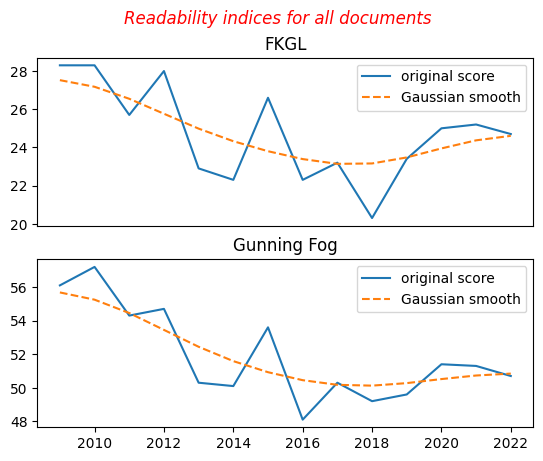

<Figure size 640x480 with 0 Axes>

In [126]:
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

fig, axes = plt.subplots(nrows=2, ncols=1)
plt.suptitle('Readability indices for all documents', color='red', style='italic')
ax1, ax2 = axes.flatten()

ysmoothed = gaussian_filter1d(y, sigma=2)

data = df.groupby(['Год']).agg(
    {'FKGL': 'mean',
     'GunFog': 'mean'}
         ).apply(lambda x: round(x, 1))

y = data['FKGL'].to_list()
y_smoothed = gaussian_filter1d(y, sigma=2)
x = [year for year in range(2009, 2023)]

ax1.plot(x, y, label='original score')
ax1.plot(x, y_smoothed, label='Gaussian smooth', linestyle='dashed')
ax1.set_title('FKGL')
ax1.get_xaxis().set_visible(False)
ax1.legend()

y = data['GunFog'].to_list()
y_smoothed = gaussian_filter1d(y, sigma=2)
x = [year for year in range(2009, 2023)]
ax2.set_title('Gunning Fog')



ax2.plot(x, y, label='original score')
ax2.plot(x, y_smoothed, label='Gaussian smooth', linestyle='dashed')
ax2.legend()

figure(figsize=(8, 6), dpi=80)




In [32]:
df[['Текст',
    'FKGL',
    'GunFog',
    "Год",
    'Название документа']].groupby(['Год']).agg({'FKGL': 'mean',
                                                 'GunFog': 'mean'}).apply(lambda x: round(x, 1))

,FKGL,GunFog
Год,,
2009,28.3,56.1
2010,28.3,57.2
2011,25.7,54.3
2012,28.0,54.7
2013,22.9,50.3
2014,22.3,50.1
2015,26.6,53.6
2016,22.3,48.1
2017,23.2,50.3
